In [42]:
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
from math import sqrt
import matplotlib.pyplot as plt
from ecell4.extra import ensemble
import numpy as np
from math import pi

def wrap(job,job_id,task_id):
    def singlerun(kaf,run,correct,Da,Db,shift):
        import numpy as np
        from math import sqrt
        L=6.5
        N=100
        rm = 0.005
        run+=shift
        rng = GSLRandomNumberGenerator()
        rng.seed(run)
        D = 1
        kd= 4.0*math.pi*D
        ka = kaf*kd
        f=1.0208582         
        if correct=='new':
            gamma=0.577216
            factor = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))            
            PP=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*gamma)/2/math.pi)
            ka = PP*D/factor            
        voxelr=rm*f
        H = 3*voxelr*2
        ori = Real3(0.5*H,0,0)
        unit0 = Real3(0,0,L)
        unit1 = Real3(0,L,0)
        w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),voxelr,rng)
        size=tuple(w.calculate_shape(Real3(H,L,L),voxelr))
        Nmv=size[1]*size[2]
        lx,ly,lz=w.actual_lengths()
        #N=int(conc*ly*lz)
        Area = ly*lz
        with species_attributes():
            A |  {'D': str(Da), 'radius':str(voxelr),'location':'X'}
            B |  {'D': str(Db), 'radius':str(voxelr),'location':'X'}           
            
        with reaction_rules():#for spa and egfrd
            A + B > B | ka
            #A + B > A | ka

        m2 = get_model()
        w.bind_to(m2)
        w.add_structure(Species('X'),PlanarSurface(ori,unit0,unit1))
        w.add_molecules(Species('A'), N)
        w.add_molecules(Species('B'), N)
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        t0=sim.t()
        tsim = sim.dt()
        
        if run==1:
            print('N {},Area{},dt{},ka{},Ns{},Pa{}'.format(N,Area,sim.dt(),kaf*kd,Nmv,PP))    
        #print('dt',sim.dt())
        #change=0
        #while change==0:
        #print('current time{:.3e},simdt{:.3e}'.format(sim.t(),sim.dt()))
        if Da==0.5:
            sim.step()
        sim.step()
        #print('current time{:.3e},simdt{:.3e}'.format(sim.t(),sim.dt()))    
        res = w.num_particles_exact(Species('A'))
        tl = sim.t()
        dt = tl-t0
        #print(dt,tsim)
        change = N-res
        #kap = res*Area/sim.dt()/N/N
        #kap= Area*change/sim.dt()/N/N
        #print('ka',ka,'evaluated ka',res*Area/sim.dt()/NA/NB)        
        return change,dt,Area#kap 
    job.update({'run':task_id})
    out=singlerun(**job)
    return out

def run(simrun,kaf,cor,Da,Db,shift):
    if shift==0:
        print('kaf',kaf,'Pa',cor,'Da',Da,'Db',Db)
    nproc = 500
    jobs=[{'kaf':kaf,'correct':cor,'Da':Da,'Db':Db,'shift':shift}]    
    res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=60,modules=('numpy','ecell4','math'))[0]
    #res=ensemble.run_slurm(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'),extra_args=['--exclude=ibc[01,02,12,27]'])[0]
    #print(shift)
    res = np.array(res).T
    tsim = res[1][0]
    Area = res[2][0]
    dN=np.mean(res[0])   
    std=np.std(res[0][0])    
    if Da==0.5:
        tsim/=2
    kap = dN*Area/100/100/tsim
    #print(tsim,dN)
    #std = std*Area/100/100/tsim
    gamma=0.577216
    D=1
    kd= 4.0*math.pi*D
    ka = kaf*kd
    f=1.0208582     
    factor = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))            
    if cor=='new':
        Pa=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*gamma)/2/math.pi)
    elif cor=='ori':
        Pa = factor*ka/D
    kat=2*sqrt(3)*D*Pa
    #diff=(kat-kap)*100/kat
    #print('kat {:.4f}, kap {:.4f}+-{:.4f}, diff% {:.4f}'.format(kat,kap,diff))  
    #print(Pa)
    return kat,kap,dN    
    #print(np.count_nonzero(res)/float(simrun))
#run(2,100,'new',0.5,0.5,0)

In [2]:
run(1,100,'new',0,1,0)
run(1,100,'new',1,0,0)
run(1,100,'new',0.5,0.5,0)

kaf 100 Pa new Da 0 Db 1
N 100,Area1.028883792854046,dt2.8403327892642647e-07,ka1256.6370614359173,Ns11400,Pa91.72793663882513
kaf 100 Pa new Da 1 Db 0
N 100,Area1.028883792854046,dt2.8403327892642647e-07,ka1256.6370614359173,Ns11400,Pa91.72793663882513
kaf 100 Pa new Da 0.5 Db 0.5
N 100,Area1.028883792854046,dt5.680665578528529e-07,ka1256.6370614359173,Ns11400,Pa91.72793663882513


(317.7548934638077, 1448.9623141949633, 4.0)

In [43]:
Y = []
Nsample = 500
eachite = 1000
print('total sample',Nsample*eachite)
Da=0
Db=1
DN = []
DNth = 100*100/11400
for i in range(Nsample):
    x,y,dn = run(simrun=eachite,kaf=100,cor = 'new',Da=Da,Db=Db,shift=int(i*eachite))
    #print(int(i*eachite))
    Y.append(y)
    DN.append(dn)
print('dNsim{}expected{}'.format(np.mean(DN),DNth))
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f},std/mean %'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x),np.std(Y)*100/np.mean(Y))


total sample 500000
kaf 100 Pa new Da 0 Db 1
N 100,Area42.379903933586725,dt2.8403327892642647e-07,ka1256.6370614359173,Ns469568,Pa91.72793663882513
dNsim0.021434expected0.8771929824561403
expected=317.7549,sim=319.8114,+-70.4690,absdiff=-2.0565,diff%=-0.6472,std/mean % 22.034548545157076


500 samples, each sample has 1000 iteration


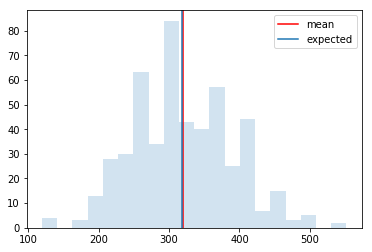

In [44]:
plt.hist(Y,bins=20,alpha=0.2)
plt.axvline(np.mean(Y),c='r',label='mean')
plt.axvline(x,label='expected')
plt.legend()
print('{} samples, each sample has {} iteration'.format(Nsample,eachite))

In [34]:
Y = []
Nsample = 500
eachite = 1000
print('total sample',Nsample*eachite)
Da=0
Db=1
DN = []
DNth = 100*100/11400
for i in range(Nsample):
    x,y,dn = run(simrun=eachite,kaf=100,cor = 'new',Da=Da,Db=Db,shift=int(i*eachite))
    #print(int(i*eachite))
    Y.append(y)
    DN.append(dn)
print('dNsim{}expected{}'.format(np.mean(DN),DNth))
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f},std/mean %'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x),np.std(Y)*100/np.mean(Y))


total sample 500000
kaf 100 Pa new Da 0 Db 1
N 100,Area1.028883792854046,dt2.8403327892642647e-07,ka1256.6370614359173,Ns11400,Pa91.72793663882513
dNsim0.875242expected0.8771929824561403
expected=317.7549,sim=317.0482,+-11.5819,absdiff=0.7067,diff%=0.2224,std/mean % 3.653051651150781


500 samples, each sample has 1000 iteration


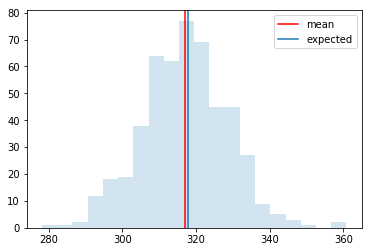

In [36]:
plt.hist(Y,bins=20,alpha=0.2)
plt.axvline(np.mean(Y),c='r',label='mean')
plt.axvline(x,label='expected')
plt.legend()
print('{} samples, each sample has {} iteration'.format(Nsample,eachite))

In [37]:
Y = []
Nsample = 500
eachite = 1000
print('total sample',Nsample*eachite)
Da=1
Db=0
DN = []
DNth = 100*100/11400
for i in range(Nsample):
    x,y,dn = run(simrun=eachite,kaf=100,cor = 'new',Da=Da,Db=Db,shift=int(i*eachite))
    #print(int(i*eachite))
    Y.append(y)
    DN.append(dn)
print('dNsim{}expected{}'.format(np.mean(DN),DNth))
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f},std/mean %'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x),np.std(Y)*100/np.mean(Y))


total sample 500000
kaf 100 Pa new Da 1 Db 0
N 100,Area1.028883792854046,dt2.8403327892642647e-07,ka1256.6370614359173,Ns11400,Pa91.72793663882513
dNsim0.8770979999999999expected0.8771929824561403
expected=317.7549,sim=317.7205,+-10.5490,absdiff=0.0344,diff%=0.0108,std/mean % 3.3202000077891713


500 samples, each sample has 1000 iteration


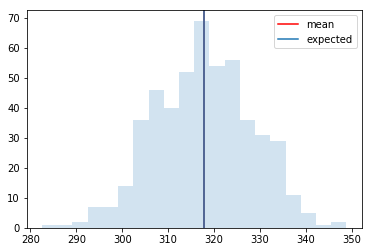

In [41]:
plt.hist(Y,bins=20,alpha=0.2)
plt.axvline(np.mean(Y),c='r',label='mean')
plt.axvline(x,label='expected')
plt.legend()
print('{} samples, each sample has {} iteration'.format(Nsample,eachite))

In [65]:
Y = []
sr = 500000
num = 20
Da=1
Db=0
DN = []
DNth = 100*100/11400
for i in range(num):
    x,y,dn = run(simrun=int(sr/num),kaf=100,cor = 'new',Da=Da,Db=Db,shift=int(int(sr/num)*i))
    Y.append(y)
    DN.append(dn)
print('dNsim{}expected{}'.format(np.mean(DN),DNth))
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f},std/mean %'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x),np.std(Y)*100/np.mean(Y))

kaf 100 Pa new Da 1 Db 0
N 100,Area1.028883792854046,dt2.8403327892642647e-07,ka1256.6370614359173,Ns11400,Pa91.72793663882513
dNsim0.8770979999999999expected0.8771929824561403
expected=317.7549,sim=317.7205,+-1.8943,absdiff=0.0344,diff%=0.0108,std/mean % 0.5962145409973576


In [110]:
Y = []
sr = 500000
num = 20
Da=0.5
Db=0.5
DN = []
DNth = 100*100/11400
for i in range(num):
    x,y,dn = run(simrun=int(sr/num),kaf=100,cor = 'new',Da=Da,Db=Db,shift=int(int(sr/num)*i))
    Y.append(y)
    DN.append(dn)
print('dNsim{}expected{}'.format(np.mean(DN),DNth))
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f},std/mean %'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x),np.std(Y)*100/np.mean(Y))

kaf 100 Pa new Da 0.5 Db 0.5
N 100,Area1.028883792854046,dt5.680665578528529e-07,ka1256.6370614359173,Ns11400,Pa91.72793663882513
dNsim1.599368expected0.8771929824561403
expected=317.7549,sim=579.3560,+-3.0820,absdiff=-261.6011,diff%=-82.3280,std/mean % 0.5319699423290817


In [117]:
dc=100*100/11400
dc+(100-dc)*100/11400

1.7466912896275777

In [40]:
run(5000,100,'new',1,0,0)

kaf 100 Pa new Da 1 Db 0
N 100,Area42.379903933586725,dt2.8403327892642647e-07,ka1256.6370614359173,Ns469568,Pa91.72793663882513


(317.7548934638077, 244.70034889498177)

In [41]:
run(5000,100,'new',0,1,0)

kaf 100 Pa new Da 0 Db 1
N 100,Area42.379903933586725,dt2.8403327892642647e-07,ka1256.6370614359173,Ns469568,Pa91.72793663882513


(317.7548934638077, 268.57355366522387)

In [29]:
SR=100000

In [30]:
Y = []
sr = SR
num = 20
Da=0
Db=1
for i in range(num):
    x,y = run(simrun=int(sr/num),kaf=100,cor = 'new',Da=Da,Db=Db,shift=int(int(sr/num)*i))
    Y.append(y)
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f},std/mean %'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x),np.std(Y)*100/np.mean(Y))

kaf 100 Pa new Da 0 Db 1
N 100,Area42.379903933586725,dt2.8403327892642647e-07,ka1256.6370614359173,Ns469568,Pa91.72793663882513
expected=317.7549,sim=314.2311,+-20.9125,absdiff=3.5238,diff%=1.1090,std/mean % 6.655130805487931


In [31]:
Y = []
sr = SR
num = 20
Da=1
Db=0
for i in range(num):
    x,y = run(simrun=int(sr/num),kaf=100,cor = 'new',Da=Da,Db=Db,shift=int(int(sr/num)*i))
    Y.append(y)
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f},std/mean %'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x),np.std(Y)*100/np.mean(Y))

kaf 100 Pa new Da 1 Db 0
N 100,Area42.379903933586725,dt2.8403327892642647e-07,ka1256.6370614359173,Ns469568,Pa91.72793663882513
expected=317.7549,sim=315.7231,+-27.2621,absdiff=2.0318,diff%=0.6394,std/mean % 8.634824646923434


In [32]:
Y = []
sr = SR
num = 20
Da=0.5
Db=0.5
for i in range(num):
    x,y = run(simrun=int(sr/num),kaf=100,cor = 'new',Da=Da,Db=Db,shift=int(int(sr/num)*i))
    Y.append(y)
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f},std/mean %'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x),np.std(Y)*100/np.mean(Y))

kaf 100 Pa new Da 0.5 Db 0.5
N 100,Area42.379903933586725,dt5.680665578528529e-07,ka1256.6370614359173,Ns469568,Pa91.72793663882513
expected=317.7549,sim=315.7231,+-27.2621,absdiff=2.0318,diff%=0.6394,std/mean % 8.634824646923434


In [31]:
SR=200

In [116]:
run(simrun=1,kaf=100,conc = 10,cor = 'new',shift=0)

kaf 100 conc 10 Pa new
N 423,Area42.379903933586725,dt2.8403327892642647e-07,ka1256.6370614359173,Nv469568
0.0
kat 317.7549, kap 0.0000+-0.0000, diff% 100.0000


(317.7548934638077, 0.0)

In [86]:
Y = []
sr = 100000
num = 10
for i in range(num):
    x,y = run(simrun=int(sr/num),kaf=100,conc = 10,cor = 'new',shift=int(int(sr/num)*i))
    Y.append(y)
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f}'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x))

kaf 100 conc 10 Pa new
0.322
kat 317.7549, kap 322.7997+-517.8556, diff% -1.5877
kaf 100 conc 10 Pa new
0.3143
kat 317.7549, kap 318.2133+-517.4041, diff% -0.1443
kaf 100 conc 10 Pa new
0.3197
kat 317.7549, kap 319.2140+-513.6832, diff% -0.4592
kaf 100 conc 10 Pa new
0.3114
kat 317.7549, kap 314.7110+-518.7382, diff% 0.9579
kaf 100 conc 10 Pa new
0.3185
kat 317.7549, kap 320.2147+-517.2446, diff% -0.7741
kaf 100 conc 10 Pa new
0.3176
kat 317.7549, kap 322.7164+-521.8534, diff% -1.5614
kaf 100 conc 10 Pa new
0.3122
kat 317.7549, kap 310.8751+-509.3029, diff% 2.1651
kaf 100 conc 10 Pa new
0.3142
kat 317.7549, kap 318.0466+-519.6522, diff% -0.0918
kaf 100 conc 10 Pa new
0.3148
kat 317.7549, kap 313.8771+-510.4641, diff% 1.2204
kaf 100 conc 10 Pa new
0.313
kat 317.7549, kap 310.4581+-504.8271, diff% 2.2963
expected=317.7549,sim=317.1126,+-4.2343,absdiff=0.6423,diff%=0.2021


In [123]:
N=423
rm=0.005
Area=42.379903933586725
dt = 2.8403327892642647e-7
kaa=316.45311481766623
ka=1256.6370614359173
ch = 317.1126*dt*N*N/Area
td =(2*rm*f)**2/(4*D)   
Ns=469568
Pa=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*gamma)/2/math.pi)
alpha = 1./Pa
Z=N*N*dt/Ns/td/alpha
kl=2*sqrt(3)*Pa*D
ch,ka*N*N*dt/Area,Z*Pa*alpha,kl*N*N*dt/Area

(0.38028000648577875,
 1.5069535233640057,
 0.3810502419244922,
 0.38105024192449233)

In [87]:
Y = []
sr = 100000
num = 10
for i in range(num):
    x,y = run(simrun=int(sr/num),kaf=0.01,conc = 10,cor = 'new',shift=int(int(sr/num)*i))
    Y.append(y)
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f}'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x))

kaf 0.01 conc 10 Pa new
0.015
kat 0.1256, kap 0.1409+-1.1592, diff% -12.1653
kaf 0.01 conc 10 Pa new
0.0122
kat 0.1256, kap 0.1109+-0.9980, diff% 11.7151
kaf 0.01 conc 10 Pa new
0.0141
kat 0.1256, kap 0.1291+-1.0832, diff% -2.7579
kaf 0.01 conc 10 Pa new
0.0148
kat 0.1256, kap 0.1355+-1.1089, diff% -7.8234
kaf 0.01 conc 10 Pa new
0.0147
kat 0.1256, kap 0.1345+-1.1052, diff% -7.0998
kaf 0.01 conc 10 Pa new
0.0134
kat 0.1256, kap 0.1227+-1.0570, diff% 2.3076
kaf 0.01 conc 10 Pa new
0.0138
kat 0.1256, kap 0.1255+-1.0605, diff% 0.1367
kaf 0.01 conc 10 Pa new
0.0148
kat 0.1256, kap 0.1345+-1.0977, diff% -7.0998
kaf 0.01 conc 10 Pa new
0.0139
kat 0.1256, kap 0.1282+-1.0872, diff% -2.0342
kaf 0.01 conc 10 Pa new
0.0126
kat 0.1256, kap 0.1155+-1.0261, diff% 8.0968
expected=0.1256,sim=0.1277,+-0.0089,absdiff=-0.0021,diff%=-1.6724


In [90]:
Y = []
sr = 100000
num = 10
for i in range(num):
    x,y = run(simrun=int(sr/num),kaf=0.1,conc = 10,cor = 'new',shift=int(int(sr/num)*i))
    Y.append(y)
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f}'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x))

kaf 0.1 conc 10 Pa new
0.132
kat 1.2529, kap 1.2855+-3.4161, diff% -2.5957
kaf 0.1 conc 10 Pa new
0.1293
kat 1.2529, kap 1.2573+-3.3890, diff% -0.3465
kaf 0.1 conc 10 Pa new
0.1329
kat 1.2529, kap 1.2955+-3.4232, diff% -3.3939
kaf 0.1 conc 10 Pa new
0.127
kat 1.2529, kap 1.2473+-3.3988, diff% 0.4517
kaf 0.1 conc 10 Pa new
0.1364
kat 1.2529, kap 1.3236+-3.4498, diff% -5.6431
kaf 0.1 conc 10 Pa new
0.1275
kat 1.2529, kap 1.2309+-3.3212, diff% 1.7577
kaf 0.1 conc 10 Pa new
0.1266
kat 1.2529, kap 1.2236+-3.3114, diff% 2.3382
kaf 0.1 conc 10 Pa new
0.1268
kat 1.2529, kap 1.2527+-3.4355, diff% 0.0163
kaf 0.1 conc 10 Pa new
0.1306
kat 1.2529, kap 1.2818+-3.4416, diff% -2.3055
kaf 0.1 conc 10 Pa new
0.1226
kat 1.2529, kap 1.1882+-3.2856, diff% 5.1679
expected=1.2529,sim=1.2586,+-0.0374,absdiff=-0.0057,diff%=-0.4553


In [88]:
Y = []
sr = 100000
num = 10
for i in range(num):
    x,y = run(simrun=int(sr/num),kaf=10,conc = 10,cor = 'new',shift=int(int(sr/num)*i))
    Y.append(y)
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f}'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x))

kaf 10 conc 10 Pa new
0.3219
kat 97.0021, kap 98.4913+-158.0783, diff% -1.5352
kaf 10 conc 10 Pa new
0.3143
kat 97.0021, kap 97.1166+-157.9038, diff% -0.1180
kaf 10 conc 10 Pa new
0.3197
kat 97.0021, kap 97.4985+-156.8235, diff% -0.5117
kaf 10 conc 10 Pa new
0.3108
kat 97.0021, kap 95.9202+-158.3268, diff% 1.1154
kaf 10 conc 10 Pa new
0.3185
kat 97.0021, kap 97.8294+-158.0383, diff% -0.8528
kaf 10 conc 10 Pa new
0.3175
kat 97.0021, kap 98.5422+-159.3939, diff% -1.5877
kaf 10 conc 10 Pa new
0.3121
kat 97.0021, kap 94.8510+-155.4243, diff% 2.2176
kaf 10 conc 10 Pa new
0.3147
kat 97.0021, kap 97.2439+-158.7875, diff% -0.2492
kaf 10 conc 10 Pa new
0.3153
kat 97.0021, kap 95.9965+-155.9917, diff% 1.0367
kaf 10 conc 10 Pa new
0.3132
kat 97.0021, kap 94.8764+-154.1738, diff% 2.1914
expected=97.0021,sim=96.8366,+-1.2902,absdiff=0.1655,diff%=0.1706


In [89]:
Y = []
sr = 100000
num = 10
for i in range(num):
    x,y = run(simrun=int(sr/num),kaf=1,conc = 10,cor = 'new',shift=int(int(sr/num)*i))
    Y.append(y)
print('expected={:.4f},sim={:.4f},+-{:.4f},absdiff={:.4f},diff%={:.4f}'.format(x,np.mean(Y),np.std(Y),x-np.mean(Y),(x-np.mean(Y))*100/x))

kaf 1 conc 10 Pa new
0.3211
kat 12.2057, kap 12.3803+-19.9092, diff% -1.4302
kaf 1 conc 10 Pa new
0.3155
kat 12.2057, kap 12.2682+-19.8832, diff% -0.5117
kaf 1 conc 10 Pa new
0.3203
kat 12.2057, kap 12.2618+-19.6902, diff% -0.4592
kaf 1 conc 10 Pa new
0.3113
kat 12.2057, kap 12.1080+-19.9863, diff% 0.8005
kaf 1 conc 10 Pa new
0.3195
kat 12.2057, kap 12.3098+-19.7980, diff% -0.8528
kaf 1 conc 10 Pa new
0.3172
kat 12.2057, kap 12.3771+-20.0063, diff% -1.4040
kaf 1 conc 10 Pa new
0.312
kat 12.2057, kap 11.9895+-19.6363, diff% 1.7715
kaf 1 conc 10 Pa new
0.3141
kat 12.2057, kap 12.2233+-19.9931, diff% -0.1443
kaf 1 conc 10 Pa new
0.3152
kat 12.2057, kap 12.0664+-19.6205, diff% 1.1416
kaf 1 conc 10 Pa new
0.313
kat 12.2057, kap 11.9479+-19.4280, diff% 2.1126
expected=12.2057,sim=12.1932,+-0.1479,absdiff=0.0125,diff%=0.1024


In [32]:
run(simrun=SR,kaf=100,conc = 10,cor = 'new')
run(simrun=SR,kaf=100,conc = 10,cor = 'ori')

kaf 100 conc 10 Pa new
0.335
kat 317.7549, kap 337.7264+-534.5862, diff% -6.2852
kaf 100 conc 10 Pa ori
0.335
kat 1261.8064, kap 1341.1135+-2122.8446, diff% -6.2852


In [37]:
run(simrun=SR,kaf=0.01,conc = 10,cor = 'ori')
run(simrun=SR,kaf=0.01,conc = 10,cor = 'new')

kaf 0.01 conc 10 Pa ori
0.025
kat 0.1262, kap 0.2273+-1.4193, diff% -80.1174
kaf 0.01 conc 10 Pa new
0.025
kat 0.1256, kap 0.2273+-1.4193, diff% -80.9118


In [35]:
for conc in [10,20,30,40,50,60]:
    run(simrun=SR,kaf=100,conc = conc,cor = 'new')

kaf 100 conc 10 Pa new
0.335
kat 317.7549, kap 337.7264+-534.5862, diff% -6.2852
kaf 100 conc 20 Pa new
0.77
kat 317.7549, kap 341.0890+-274.3775, diff% -7.3434
kaf 100 conc 30 Pa new
0.975
kat 317.7549, kap 333.8935+-165.9144, diff% -5.0789
kaf 100 conc 40 Pa new
0.995
kat 317.7549, kap 311.6037+-138.8687, diff% 1.9358
kaf 100 conc 50 Pa new
1.0
kat 317.7549, kap 330.1181+-112.6933, diff% -3.8908
kaf 100 conc 60 Pa new
1.0
kat 317.7549, kap 320.0390+-86.0901, diff% -0.7188


In [36]:
for conc in [10,20,30,40,50,60]:
    run(simrun=SR,kaf=0.01,conc = conc,cor = 'new')

kaf 0.01 conc 10 Pa new
0.025
kat 0.1256, kap 0.2273+-1.4193, diff% -80.9118
kaf 0.01 conc 20 Pa new
0.035
kat 0.1256, kap 0.0794+-0.4167, diff% 36.8303
kaf 0.01 conc 30 Pa new
0.14
kat 0.1256, kap 0.1460+-0.3686, diff% -16.2210
kaf 0.01 conc 40 Pa new
0.19
kat 0.1256, kap 0.1189+-0.2569, diff% 5.3572
kaf 0.01 conc 50 Pa new
0.32
kat 0.1256, kap 0.1378+-0.2281, diff% -9.6830
kaf 0.01 conc 60 Pa new
0.375
kat 0.1256, kap 0.1183+-0.1796, diff% 5.8209


In [39]:
for sr in [200,400,800,1600]:
    run(simrun=sr,kaf=100,conc = 10,cor = 'new')

kaf 100 conc 10 Pa new
0.335
kat 317.7549, kap 337.7264+-534.5862, diff% -6.2852
kaf 100 conc 10 Pa new
0.31
kat 317.7549, kap 314.7944+-520.7615, diff% 0.9317
kaf 100 conc 10 Pa new
0.30625
kat 317.7549, kap 307.4978+-510.8388, diff% 3.2280
kaf 100 conc 10 Pa new
0.3175
kat 317.7549, kap 317.9215+-512.1134, diff% -0.0524


In [40]:
for sr in [200,400,800,1600]:
    run(simrun=sr,kaf=100,conc = 60,cor = 'new')

kaf 100 conc 60 Pa new
1.0
kat 317.7549, kap 320.0390+-86.0901, diff% -0.7188
kaf 100 conc 60 Pa new
1.0
kat 317.7549, kap 319.1731+-85.2205, diff% -0.4463
kaf 100 conc 60 Pa new
1.0
kat 317.7549, kap 318.1917+-85.2380, diff% -0.1375
kaf 100 conc 60 Pa new
1.0
kat 317.7549, kap 320.5730+-84.7845, diff% -0.8869


In [41]:
for sr in [200,400,800,1600]:
    run(simrun=sr,kaf=0.01,conc = 60,cor = 'new')

kaf 0.01 conc 60 Pa new
0.375
kat 0.1256, kap 0.1183+-0.1796, diff% 5.8209
kaf 0.01 conc 60 Pa new
0.4075
kat 0.1256, kap 0.1290+-0.1797, diff% -2.6952
kaf 0.01 conc 60 Pa new
0.40875
kat 0.1256, kap 0.1331+-0.1865, diff% -5.9514
kaf 0.01 conc 60 Pa new
0.388125
kat 0.1256, kap 0.1263+-0.1822, diff% -0.5662


In [ ]:
#longer run doesnt change std and diff much
#conc changes std and diff much

In [49]:
diff=[]
for conc in np.linspace(10,100,10):
    df = run(simrun=400,kaf=0.01,conc = conc,cor = 'new')
    diff.append(df)

kaf 0.01 conc 10.0 Pa new
0.0125
kat 0.1256, kap 0.1136+-1.0100, diff% 9.5441
kaf 0.01 conc 20.0 Pa new
0.0475
kat 0.1256, kap 0.1077+-0.4823, diff% 14.2697
kaf 0.01 conc 30.0 Pa new
0.1375
kat 0.1256, kap 0.1460+-0.3754, diff% -16.2210
kaf 0.01 conc 40.0 Pa new
0.1825
kat 0.1256, kap 0.1175+-0.2622, diff% 6.4839
kaf 0.01 conc 50.0 Pa new
0.3075
kat 0.1256, kap 0.1369+-0.2322, diff% -8.9614
kaf 0.01 conc 60.0 Pa new
0.4075
kat 0.1256, kap 0.1290+-0.1797, diff% -2.6952
kaf 0.01 conc 70.0 Pa new
0.5425
kat 0.1256, kap 0.1350+-0.1464, diff% -7.4455
kaf 0.01 conc 80.0 Pa new
0.5875
kat 0.1256, kap 0.1281+-0.1380, diff% -1.9663
kaf 0.01 conc 90.0 Pa new
0.69
kat 0.1256, kap 0.1331+-0.1240, diff% -5.9237
kaf 0.01 conc 100.0 Pa new
0.7375
kat 0.1256, kap 0.1180+-0.0999, diff% 6.0561


Text(0,0.5,'diff frm expected%')

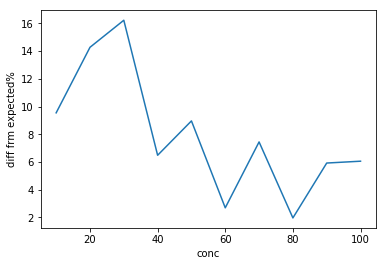

In [53]:
plt.plot(np.linspace(10,100,10),abs(np.array(diff)))
plt.xlabel('conc')
plt.ylabel('diff frm expected%')

In [54]:
diff=[]
for conc in np.linspace(10,100,10):
    df = run(simrun=400,kaf=100,conc = conc,cor = 'new')
    diff.append(df)

kaf 100 conc 10.0 Pa new
0.31
kat 317.7549, kap 314.7944+-520.7615, diff% 0.9317
kaf 100 conc 20.0 Pa new
0.78
kat 317.7549, kap 331.7299+-272.0481, diff% -4.3980
kaf 100 conc 30.0 Pa new
0.9675
kat 317.7549, kap 334.8171+-174.3779, diff% -5.3696
kaf 100 conc 40.0 Pa new
0.9925
kat 317.7549, kap 315.1092+-138.9943, diff% 0.8326
kaf 100 conc 50.0 Pa new
1.0
kat 317.7549, kap 328.8708+-105.2068, diff% -3.4983
kaf 100 conc 60.0 Pa new
1.0
kat 317.7549, kap 319.1731+-85.2205, diff% -0.4463
kaf 100 conc 70.0 Pa new
1.0
kat 317.7549, kap 316.1933+-74.2117, diff% 0.4915
kaf 100 conc 80.0 Pa new
1.0
kat 317.7549, kap 314.0705+-58.9626, diff% 1.1595
kaf 100 conc 90.0 Pa new
1.0
kat 317.7549, kap 315.8196+-58.2732, diff% 0.6091
kaf 100 conc 100.0 Pa new
1.0
kat 317.7549, kap 315.2719+-47.7257, diff% 0.7814


Text(0,0.5,'diff frm expected%')

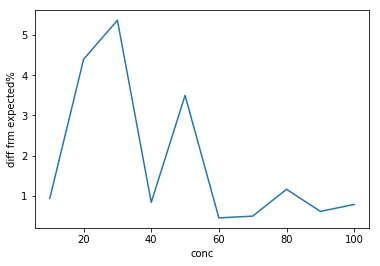

In [55]:
plt.plot(np.linspace(10,100,10),abs(np.array(diff)))
plt.xlabel('conc')
plt.ylabel('diff frm expected%')

In [ ]:
#diff reduces with conc, in the same time, fraction of rxn happen in first step increases
#std reduces as well.

In [56]:
run(simrun=400,kaf=100,conc = 200,cor = 'new')
run(simrun=400,kaf=0.01,conc = 200,cor = 'new')

kaf 100 conc 200 Pa new
1.0
kat 317.7549, kap 316.3453+-25.3018, diff% 0.4436
kaf 0.01 conc 200 Pa new
0.9925
kat 0.1256, kap 0.1238+-0.0514, diff% 1.4363


1.4363146420420148

In [57]:
run(simrun=800,kaf=100,conc = 200,cor = 'new')
run(simrun=800,kaf=0.01,conc = 200,cor = 'new')

kaf 100 conc 200 Pa new
1.0
kat 317.7549, kap 316.2492+-25.4856, diff% 0.4739
kaf 0.01 conc 200 Pa new
0.99125
kat 0.1256, kap 0.1244+-0.0517, diff% 0.9856


0.9856347821519469

In [58]:
run(simrun=400,kaf=100,conc = 400,cor = 'new')
run(simrun=400,kaf=0.01,conc = 400,cor = 'new')

kaf 100 conc 400 Pa new
1.0
kat 317.7549, kap 312.8132+-11.9091, diff% 1.5552
kaf 0.01 conc 400 Pa new
1.0
kat 0.1256, kap 0.1255+-0.0268, diff% 0.1299


0.12986048673495088

In [59]:
run(simrun=400,kaf=100,conc = 800,cor = 'new')
run(simrun=400,kaf=0.01,conc = 800,cor = 'new')

kaf 100 conc 800 Pa new
1.0
kat 317.7549, kap 308.5648+-5.9435, diff% 2.8922
kaf 0.01 conc 800 Pa new
1.0
kat 0.1256, kap 0.1265+-0.0127, diff% -0.6697


-0.6696957640305774

In [62]:
Area = 42.3799
Nv= 469568
800*Area*100/Nv

7.220236472672754

In [63]:
sr=30000
run(simrun=sr,kaf=100,conc = 10,cor = 'new')
run(simrun=sr,kaf=100,conc = 10,cor = 'ori')
run(simrun=sr,kaf=0.01,conc = 10,cor = 'new')
run(simrun=sr,kaf=0.01,conc = 10,cor = 'ori')

kaf 100 conc 10 Pa new
0.31866666666666665
kat 317.7549, kap 320.0757+-516.3215, diff% -0.7304
kaf 100 conc 10 Pa ori
0.31856666666666666
kat 1261.8064, kap 1270.4704+-2049.6769, diff% -0.6866
kaf 0.01 conc 10 Pa new
0.013766666666666667
kat 0.1256, kap 0.1270+-1.0822, diff% -1.0694
kaf 0.01 conc 10 Pa ori
0.013766666666666667
kat 0.1262, kap 0.1270+-1.0822, diff% -0.6256


-0.6255837560814193

In [100]:
2*sqrt(2)/sqrt(3),24/(6+3*sqrt(3)+2*sqrt(6))

(1.6329931618554523, 1.4911340979854824)

In [75]:
100*100/10864

0.9204712812960235

In [45]:
1./1e-7

10000000.0